In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
import scipy.stats as sp
from scipy import stats
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import mannwhitneyu

import matplotlib.pylab as plt
from matplotlib import pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import minimize
from scipy.spatial import distance

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

## Data preparation

In [2]:
#Cell fractions data derived from CIBERSORTx
result = pd.read_csv('CIBERSORTx_Job1_Results1.csv')
#result.head()

In [3]:
#Gene expression data
gene_exp=pd.read_csv('genes_used.csv',sep=",")
#gene_exp

In [4]:
#combining cytokines variables as the model
def gene_comb(data):
    #input: dataset consisting of the gene expression columns
    #output: dataset consisting the ccRCC model cytokines variables
    # gene expression data for the genes that are being used in the model
    #I2, combination of interleukin-2 and interleukin-12A and interleukin-12B
    data['I2']=data['IL12A']+data['IL12B']+data['IL2']
    #interleukin-10
    data['IL10']=data['IL10']
    #Interleukin-6
    data['IL6']=data["IL6"]
    #Interferon-gamma
    data['IFNg']=data['IFNG']
    #High mobility group box-1 (HMGB1)
    data['HMGB1']=gene_exp["HMGB1"]
    cytokines=data.loc[:,['Mixture','I2','IL10','IL6','IFNg','HMGB1']]
    cytokines=cytokines.set_index('Mixture')
    #cytokines=gene_data.drop(['Variance'])
    return cytokines
cytokines=gene_comb(gene_exp)
#cytokines

In [5]:
#Filtering the CIBERSORTx results with less than 0.05 p-values
b= result[result['P-value'] <= 0.05]
b=b.drop(['P-value','Correlation','RMSE'],axis=1)
b=b.set_index('Mixture')
#b.head()

In [6]:
#shorten pateint id by removing the dash and the last three alphanumeric value that were followed by the dash
def shorten_id(data):
    #given a dataset with patient id in the index, this function will remove the last four character of the patient id and return the data
    patient_id_rna = data.index
    dic_patient_id = {id_:id_[:-4] for id_ in patient_id_rna}
    data=data.rename(dic_patient_id, axis='index')
    data= data[~data.index.duplicated(keep='first')]
    return data

In [7]:
def model_cell(data):
    #input: cell fraction data
    #Output: New dataset with columns being the cells or combinations of cells in our model
    df=pd.DataFrame()
    df['Th']=data[['T cells CD4 memory activated','T cells follicular helper']].sum(axis=1)
    df['Tc']=data[['NK cells activated','T cells CD8']].sum(axis=1)
    df['Tr']=data[['T cells regulatory (Tregs)']]
    df['Tn']=data[['T cells CD4 naive', 'T cells CD4 memory resting','NK cells resting']].sum(axis=1)
    df['M']=data[['Macrophages M1', 'Macrophages M2']].sum(axis=1)
    df['Mn']=data[['Macrophages M0','Monocytes']].sum(axis=1)
    df['D']=data[['Dendritic cells activated']]
    df['Dn']=data[['Dendritic cells resting']]
    df['C']=""
    df['N']=""
    df["TIC"]=df.sum(axis=1)
    df=shorten_id(df)
    return df

In [8]:
#Cell variables that would be used in the model
cell_data=model_cell(b)
#cell_data

In [9]:
#combine cells in the same group
T_CD4_arr = ['T cells CD4 naive', 'T cells CD4 memory resting', 'T cells CD4 memory activated','T cells follicular helper', 'T cells regulatory (Tregs)']
NK_arr = ['NK cells resting', 'NK cells activated']
M_arr = ['Macrophages M0', 'Macrophages M1', 'Macrophages M2']
Mast_arr=['Mast cells resting',
 'Mast cells activated']
DC_arr = ['Dendritic cells resting', 'Dendritic cells activated']

In [10]:
def add_columns(df):
    df['T cells CD4'] = df[T_CD4_arr].sum(axis=1)
    df['NK cells'] = df[NK_arr].sum(axis=1)
    df['Macrophages'] = df[M_arr].sum(axis=1)
    df['Mast cells']=df[Mast_arr].sum(axis=1)
    df['DC'] = df[DC_arr].sum(axis=1)
    return df

In [11]:
Ciber_result=add_columns(b)
#drop subcells that have been included in the model variables
Ciber_result=Ciber_result.drop(['Dendritic cells resting', 'Dendritic cells activated','Macrophages M0', 'Macrophages M1', 'Macrophages M2',
                          'T cells follicular helper',
 'T cells regulatory (Tregs)','NK cells resting', 'NK cells activated','T cells CD4 naive', 'T cells CD4 memory resting', 'T cells CD4 memory activated', 
         'Mast cells resting',
 'Mast cells activated','B cells naive', 'B cells memory'],axis=1)
#Ciber_result

In [12]:
Ciber_result=Ciber_result.rename({'T cells CD8':'CD8 T cells','T cells CD4':'CD4 T cells'},axis='columns')
#Ciber_result

In [13]:
#gene mixture data with hugo symbol
mixture = pd.read_csv('Filtered_TCGA_Mixture.csv',sep=',')
mixture=mixture.rename(columns={'Unnamed: 0':'Mixture'})
#mixture[['Hugo_Symbol']] = mixture[['Hugo_Symbol']].astype(str)
mixture=mixture.set_index(['Mixture'])
#mixture=mixture.T
#mixture

In [14]:
clinical_data = pd.read_csv('clinical_data_NEW.csv')
clinical_data=clinical_data.set_index(['PATIENT_ID'])
#clinical_data=clinical_data.drop(['RGS5','RGS5 level'],axis=1)
#clinical_data.head()

In [15]:
patients_cBio = clinical_data.index.values
mixture_patients = mixture.index.values

patients_ = [patient for patient in patients_cBio if patient not in mixture_patients]
patients_2= [patient for patient in mixture_patients if patient not in patients_cBio]
clinical_data = clinical_data.drop(index= patients_)

In [16]:
clinical = pd.concat([clinical_data, mixture], axis=1, sort=False)
#clinical

In [17]:
#shorten patient id in cibersort result to match patient id in clinical data
Ciber_result=shorten_id(Ciber_result)
#Ciber_result

In [18]:
patients_cBio = clinical.index.values
mixture_patients = Ciber_result.index.values

patients_ = [patient for patient in patients_cBio if patient not in mixture_patients]
#patients_2= [patient for patient in mixture_patients if patient not in patients_cBio]



clinical = clinical.drop(index= patients_)
clinical = pd.concat([clinical, Ciber_result], axis=1, sort=False)
#clinical.head()

## Clustering

In [19]:
cell_proportions=Ciber_result
cell_proportions.head()

,Plasma cells,CD8 T cells,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC
Mixture,,,,,,,,,,,
TCGA-B2-4101,0.010362,0.270138,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404
TCGA-BP-4342,0.000000,0.117228,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841
TCGA-B0-4691,0.049794,0.400383,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197
TCGA-BP-4167,0.002018,0.325929,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931
TCGA-B8-4620,0.001936,0.024904,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219


In [20]:
#K-means algorithm
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,12) 
  
for k in K: 
    #k-means clustering on patients immune infiltration
    kmeanModel = KMeans(n_clusters=k).fit(cell_proportions) 
    kmeanModel.fit(cell_proportions)     
      
    distortions.append(sum(np.min(cdist(cell_proportions, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / cell_proportions.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(cell_proportions, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / cell_proportions.shape[0] 
          
    mapping2[k] = kmeanModel.inertia_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_mea

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

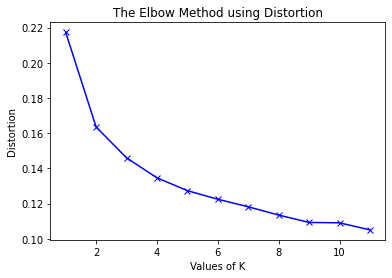

In [21]:
plt.figure
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [22]:
kmeans = KMeans(n_clusters=4)

y = kmeans.fit_predict(cell_proportions)

cell_proportions['4_clusters'] = y

cell_proportions.head()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

,Plasma cells,CD8 T cells,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC,4_clusters
Mixture,,,,,,,,,,,,
TCGA-B2-4101,0.010362,0.270138,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404,0
TCGA-BP-4342,0.000000,0.117228,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841,3
TCGA-B0-4691,0.049794,0.400383,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197,1
TCGA-BP-4167,0.002018,0.325929,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931,0
TCGA-B8-4620,0.001936,0.024904,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219,2


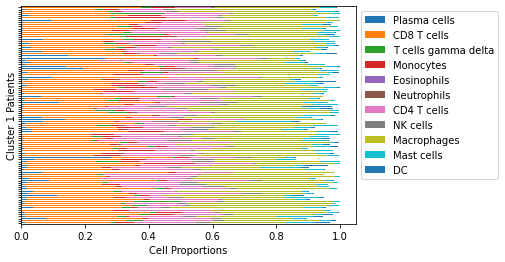

In [23]:
#Cluster 1 cell frequency bar graph
c1=cell_proportions[cell_proportions['4_clusters']==0]
c1=c1.iloc[:,:11]
c1.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
plt.ylabel('Cluster 1 Patients')
plt.xlabel('Cell Proportions')
plt.show()

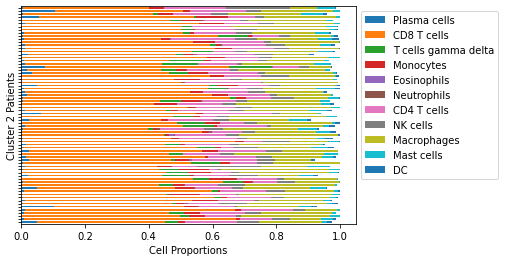

In [24]:
#Cluster 2 cell frequency bar graph
c2=cell_proportions[cell_proportions['4_clusters']==1]
c2=c2.iloc[:,:11]
c2.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
plt.ylabel('Cluster 2 Patients')
plt.xlabel('Cell Proportions')
plt.show()

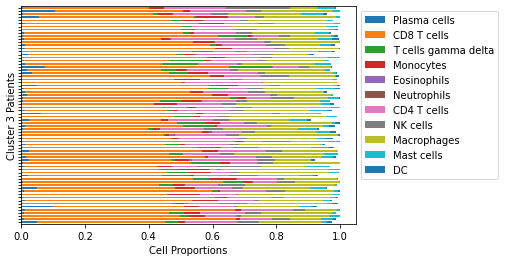

In [25]:
#Cluster 3 cell frequency bar graph
c3=cell_proportions[cell_proportions['4_clusters']==2]
c3=c2.iloc[:,:11]
c3.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
plt.ylabel('Cluster 3 Patients')
plt.xlabel('Cell Proportions')
plt.show()

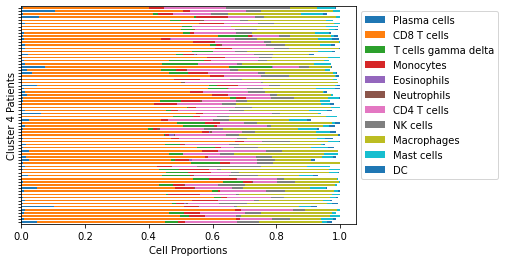

In [26]:
#Cluster 4 cell frequency bar graph
c4=cell_proportions[cell_proportions['4_clusters']==3]
c4=c2.iloc[:,:11]
c4.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
plt.ylabel('Cluster 4 Patients')
plt.xlabel('Cell Proportions')
plt.show()

In [27]:
a=cell_proportions

In [28]:
clinical = pd.concat([clinical, a], axis=1, sort=False)
clinical

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,DAYS_TO_BIRTH,RACE,...,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC,4_clusters
TCGA-6D-AA2E,D3B47E53-6F40-4FC8-B5A4-CBE548A770A9,3/17/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Female,-25043,BLACK OR AFRICAN AMERICAN,...,0.000000,0.047463,0.0,0.000000,0.175845,0.033703,0.197386,0.035076,0.005309,3
TCGA-A3-3307,7ac1d6c6-9ade-49af-8794-10b5b96b2b05,4/13/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,-24315,[Not Available],...,0.010723,0.148006,0.0,0.016171,0.088869,0.000000,0.387997,0.032609,0.001176,0
TCGA-A3-3308,3cbca837-f5a7-4a87-8f02-c59eac232d5a,4/12/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Female,-28287,WHITE,...,0.000000,0.085013,0.0,0.000000,0.161532,0.035343,0.517407,0.060260,0.000000,2
TCGA-A3-3311,0c139772-e303-45d1-b0c7-438fa1db105e,4/20/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Male,-21183,[Not Available],...,0.023851,0.149907,0.0,0.004012,0.184432,0.002508,0.312352,0.038168,0.000838,3
TCGA-A3-3316,12c4c4f1-5880-4bf9-9945-80bf45415de6,4/14/10,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,-20931,WHITE,...,0.001664,0.124343,0.0,0.012655,0.156143,0.017623,0.559328,0.033108,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-G6-A8L6,28011111-4A01-4CDC-8D6B-7223FB2C501B,4/3/14,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,-20306,BLACK OR AFRICAN AMERICAN,...,0.000000,0.225515,0.0,0.000000,0.282635,0.064192,0.203699,0.012928,0.000000,3
TCGA-GK-A6C7,0DF9EC46-D600-4845-9D00-2DC2732C68D1,11/26/13,Kidney Clear Cell Renal Carcinoma,[Not Available],Right,YES,NO,Female,-28107,BLACK OR AFRICAN AMERICAN,...,0.000000,0.091200,0.0,0.000000,0.149444,0.149984,0.244331,0.097449,0.037781,3
TCGA-MM-A563,FE1F95A3-A6C2-4A39-8586-F8A70E975DD4,6/14/13,Kidney Clear Cell Renal Carcinoma,G2,Left,NO,YES,Male,-15037,BLACK OR AFRICAN AMERICAN,...,0.040108,0.063753,0.0,0.000000,0.183812,0.017904,0.342389,0.053661,0.031016,3
TCGA-MM-A564,620BAEFA-DB8F-4AF9-9101-4B9B252FA73E,6/14/13,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Male,-24916,BLACK OR AFRICAN AMERICAN,...,0.000000,0.176563,0.0,0.000000,0.118008,0.305846,0.223362,0.082929,0.000000,3


In [29]:
clinical=clinical.rename(columns={"4_clusters":"Clusters"})
clinical['Clusters']=clinical['Clusters'].map({0:'Cluster 1',1:'Cluster 2',2:'Cluster 3',3:'Cluster 4'})

In [30]:
cytokines=shorten_id(cytokines)
cytokines

,I2,IL10,IL6,IFNg,HMGB1
Mixture,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734
...,...,...,...,...,...
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659
TCGA-CJ-4640,0.045822,0.044328,0.044438,0.127557,0.367635


In [31]:
#Combined data of cells and genes
cell_gene_comb=pd.concat([cytokines,cell_data,cell_proportions],axis=1)
cell_gene_comb=cell_gene_comb.dropna()
cell_gene_comb

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,...,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC,4_clusters
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,...,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404,0.0
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,...,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841,3.0
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,...,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197,1.0
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,...,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931,0.0
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,...,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,...,0.166096,0.000000,0.000000,0.000000,0.206913,0.007363,0.309190,0.023751,0.002814,0.0
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,...,0.015067,0.023472,0.000000,0.003103,0.142946,0.037839,0.430211,0.061277,0.009807,0.0
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,...,0.022654,0.041843,0.000091,0.008162,0.140231,0.033009,0.428706,0.008627,0.007724,0.0
TCGA-CJ-4640,0.045822,0.044328,0.044438,0.127557,0.367635,0.022855,0.388694,0.020273,0.069507,0.327684,...,0.032710,0.073924,0.000000,0.000000,0.112634,0.014028,0.327684,0.051704,0.002514,0.0


In [32]:
df_cluster=cell_gene_comb.drop(['Plasma cells', 'CD8 T cells', 'T cells gamma delta',
       'Monocytes', 'Eosinophils', 'Neutrophils', 'CD4 T cells', 'NK cells',
       'Macrophages', 'Mast cells', 'DC'],axis=1)
df_cluster

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,4_clusters
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,0.0
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,3.0
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,1.0
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,0.0
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,0.0
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,0.0
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,0.0
TCGA-CJ-4640,0.045822,0.044328,0.044438,0.127557,0.367635,0.022855,0.388694,0.020273,0.069507,0.327684,0.073924,0.000000,0.002514,,,0.905450,0.0


In [33]:
df_groups=df_cluster.groupby('4_clusters')

In [34]:
clust_1=df_groups.get_group(1)
clust_1

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,4_clusters
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,1.0
TCGA-B0-4838,0.059599,0.014286,0.018398,0.095962,0.343251,0.055505,0.725025,0.042561,0.000000,0.094644,0.010552,0.000000,0.007820,,,0.936106,1.0
TCGA-CZ-4862,0.086585,0.077689,0.056941,0.147337,0.371784,0.013627,0.514676,0.049439,0.033507,0.277686,0.051743,0.000000,0.000000,,,0.940678,1.0
TCGA-B0-5697,0.008081,0.001034,0.032692,0.001674,0.306866,0.029618,0.448943,0.056269,0.051177,0.235206,0.015470,0.000000,0.006692,,,0.843374,1.0
TCGA-BP-4968,0.044797,0.042909,0.078687,0.113973,0.349957,0.046720,0.502722,0.040728,0.053749,0.222500,0.052179,0.000355,0.000000,,,0.918954,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-B8-A54D,0.030232,0.024539,0.003738,0.147751,0.318691,0.055587,0.563379,0.030864,0.038056,0.227061,0.002238,0.000000,0.008168,,,0.925353,1.0
TCGA-CJ-4635,0.033265,0.056138,0.035315,0.081414,0.347010,0.083683,0.500974,0.040174,0.000000,0.193561,0.103426,0.000000,0.004286,,,0.926104,1.0
TCGA-BP-4798,0.040254,0.039963,0.073591,0.193939,0.326896,0.021405,0.516392,0.061878,0.000000,0.226285,0.099924,0.000000,0.000000,,,0.925883,1.0
TCGA-BP-4993,0.018497,0.020857,0.077712,0.032021,0.341182,0.025985,0.458670,0.000000,0.093886,0.230024,0.047327,0.000000,0.010683,,,0.866575,1.0


In [35]:
clust_1=df_groups.get_group(0)
clust_2=df_groups.get_group(1)
clust_3=df_groups.get_group(2)
clust_4=df_groups.get_group(3)

In [36]:
phenotype=pd.read_csv('/Users/dilruba/Desktop/CancerResearch/KidneyRenal/TCGA-KIRC.GDC_phenotype.tsv',sep='\t')
phenotype.head()

,submitter_id.samples,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,...,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
0,TCGA-BP-4355-01A,NaN,NO,NO,NO,59,64.72.0,Nationwide Children's Hospital,TCGA-BP-4355-F10693,3b2086cb-fccd-417f-9193-3b8daaeb72ce,...,1.8,False,2.2,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
1,TCGA-BP-4355-11A,NaN,NO,NO,NO,59,64.72.0,Nationwide Children's Hospital,TCGA-BP-4355-F10693,3b2086cb-fccd-417f-9193-3b8daaeb72ce,...,1.3,False,2.1,NaN,NaN,Solid Tissue Normal,11,1.2,released,Not Reported
2,TCGA-A3-3359-01A,NaN,NaN,NaN,NaN,82,32.77.0,Nationwide Children's Hospital,TCGA-A3-3359-F42807,29D00B42-6889-4E5D-AD08-5B383732A001,...,0.9,False,1.0,NaN,NaN,Primary Tumor,1,0.9,released,Not Reported
3,TCGA-A3-3359-11A,NaN,NaN,NaN,NaN,82,32.77.0,Nationwide Children's Hospital,TCGA-A3-3359-F42807,29D00B42-6889-4E5D-AD08-5B383732A001,...,1.0,False,2.0,NaN,NaN,Solid Tissue Normal,11,0.5,released,Not Reported
4,TCGA-B0-4838-01A,NaN,NaN,NaN,NaN,69,65.72.0,Nationwide Children's Hospital,TCGA-B0-4838-F20781,c3f17dba-981c-4d4b-8d08-d6b18ee5cec8,...,0.5,False,2.0,NaN,NaN,Primary Tumor,1,0.4,released,Not Reported


In [37]:
phenG=phenotype.groupby('sample_type.samples')
prim_tumors=phenG.get_group('Primary Tumor')
prim_tumors=prim_tumors.rename(columns={'submitter_id.samples':'Mixture'})
prim_tumors=prim_tumors.set_index('Mixture')
prim_tumors

,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,submitter_id,...,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
Mixture,,,,,,,,,,,,,,,,,,,,,
TCGA-BP-4355-01A,NaN,NO,NO,NO,59,64.72.0,Nationwide Children's Hospital,TCGA-BP-4355-F10693,3b2086cb-fccd-417f-9193-3b8daaeb72ce,TCGA-BP-4355,...,1.8,False,2.2,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
TCGA-A3-3359-01A,NaN,NaN,NaN,NaN,82,32.77.0,Nationwide Children's Hospital,TCGA-A3-3359-F42807,29D00B42-6889-4E5D-AD08-5B383732A001,TCGA-A3-3359,...,0.9,False,1.0,NaN,NaN,Primary Tumor,1,0.9,released,Not Reported
TCGA-B0-4838-01A,NaN,NaN,NaN,NaN,69,65.72.0,Nationwide Children's Hospital,TCGA-B0-4838-F20781,c3f17dba-981c-4d4b-8d08-d6b18ee5cec8,TCGA-B0-4838,...,0.5,False,2.0,NaN,NaN,Primary Tumor,1,0.4,released,Not Reported
TCGA-BP-5001-01A,NaN,NaN,NaN,NaN,43,69.68.0,Nationwide Children's Hospital,TCGA-BP-5001-F7946,fbc19982-0148-43f7-89b0-8183544f9ee3,TCGA-BP-5001,...,0.8,False,1.5,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported
TCGA-BP-4801-01A,NaN,NaN,NaN,NaN,57,68.74.0,Nationwide Children's Hospital,TCGA-BP-4801-F7823,ed86ae6e-91b0-4d1a-8d40-00544039deac,TCGA-BP-4801,...,1.0,False,2.0,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BP-4167-01A,NaN,NaN,NaN,NaN,59,50.77.0,Nationwide Children's Hospital,TCGA-BP-4167-F7651,e299ecf4-acb9-4f8e-8c87-89bc9ef3e3af,TCGA-BP-4167,...,0.9,False,1.3,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
TCGA-CZ-4861-01A,NO,NO,NO,NO,63,65.72.0,Nationwide Children's Hospital,TCGA-CZ-4861-F7730,a4d9d858-b10e-4aeb-b269-b838087a94b7,TCGA-CZ-4861,...,0.6,False,0.8,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported
TCGA-B0-5106-01A,NaN,NaN,NaN,NaN,64,68.74.0,Nationwide Children's Hospital,TCGA-B0-5106-F31591,0b7c8a7b-eeef-46f1-8ac4-bbe9e65ef91e,TCGA-B0-5106,...,1.5,False,2.0,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported


In [38]:
#Shorten patient id in primary tumors data
prim_tumors=shorten_id(prim_tumors)

In [39]:
#prim_tumors

In [40]:
new_tumors=phenG.get_group('Additional - New Primary')
new_tumors

,submitter_id.samples,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,...,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
460,TCGA-DV-A4W0-05A,NO,NO,NO,NO,55,274.47.0,Nationwide Children's Hospital,TCGA-DV-A4W0-F52314,3DA47AE5-CF37-436F-BA04-13A4153E08F3,...,NaN,False,NaN,True,NaN,Additional - New Primary,5,NaN,released,Not Reported


In [41]:
#addinf empty columns for cancer and necrotic cells
df_cluster['C']=""
df_cluster['N']=""

In [42]:
df_cluster

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,4_clusters
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,0.0
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,3.0
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,1.0
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,0.0
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,0.0
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,0.0
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,0.0
TCGA-CJ-4640,0.045822,0.044328,0.044438,0.127557,0.367635,0.022855,0.388694,0.020273,0.069507,0.327684,0.073924,0.000000,0.002514,,,0.905450,0.0


In [43]:
phen_data=pd.concat([df_cluster,prim_tumors['intermediate_dimension.samples']],axis=1)
phen_data=phen_data.dropna()
phen_data=phen_data.rename(columns={'intermediate_dimension.samples':'dim'})
phen_data

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,4_clusters,dim
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,0.0,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,3.0,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,1.0,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,0.0,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,2.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,0.0,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,0.0,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,0.0,0.9
TCGA-CJ-4640,0.045822,0.044328,0.044438,0.127557,0.367635,0.022855,0.388694,0.020273,0.069507,0.327684,0.073924,0.000000,0.002514,,,0.905450,0.0,0.7


In [44]:
#grouping different clusters
groups=phen_data.groupby('4_clusters')

In [45]:
# Storing the dimensions of each patient
dims=phen_data[['dim']]
dims

,dim
TCGA-B2-4101,0.7
TCGA-BP-4342,1.1
TCGA-B0-4691,1.5
TCGA-BP-4167,0.9
TCGA-B8-4620,0.8
...,...
TCGA-AK-3434,0.9
TCGA-BP-4782,0.6
TCGA-CJ-4895,0.9
TCGA-CJ-4640,0.7


In [46]:
means=groups.mean()
mean_dim=means.iloc[:,-1]
mean_TIC=means.iloc[:,-2]
print(means)
print(mean_dim)
print(mean_TIC)

                  I2      IL10       IL6      IFNg     HMGB1        Th  \
4_clusters                                                               
0.0         0.033911  0.039268  0.105428  0.057377  0.338086  0.036413   
1.0         0.043533  0.045161  0.055545  0.109728  0.338087  0.054158   
2.0         0.023846  0.052766  0.128028  0.020760  0.330829  0.016485   
3.0         0.030095  0.038854  0.091756  0.027477  0.349584  0.016691   

                  Tc        Tr        Tn         M        Mn         D  \
4_clusters                                                               
0.0         0.315722  0.034724  0.120329  0.273124  0.078415  0.000341   
1.0         0.540439  0.046170  0.028856  0.189097  0.042994  0.000033   
2.0         0.119884  0.025292  0.154399  0.370825  0.192441  0.002825   
3.0         0.148324  0.024324  0.229810  0.285813  0.106296  0.001146   

                  Dn       TIC       dim  
4_clusters                                
0.0         0.009698  0.

In [47]:
df_cluster.index=pd.Index(list(df_cluster.index),name='Mixture')
df_cluster

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,4_clusters
Mixture,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,0.0
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,3.0
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,1.0
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,0.0
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,0.0
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,0.0
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,0.0


In [48]:
gene_cell_dim=pd.concat([df_cluster,prim_tumors['intermediate_dimension.samples']],axis=1)
gene_cell_dim.index=pd.Index(list(gene_cell_dim.index),name="Mixture")
gene_cell_dim=gene_cell_dim.rename(columns={'intermediate_dimension.samples':'dim','4_clusters':'clusters'})
gene_cell_dim=gene_cell_dim.dropna()
gene_cell_dim

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,clusters,dim
Mixture,,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,0.0,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,3.0,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,1.0,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,0.0,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,2.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,0.0,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,0.0,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,0.0,0.9


In [49]:
#total cell number TCN 
#in a study epithelial cell 63% immune cell 16% stroma 20%
#assume C:I:N ratio 0.6:0.3:0.1
# Evaluating number of cancer and necrotic cells from tumor size and immune cells

#I choose 4.5e1 value, this value should have been found in the literature.
def cell_pop_right(clust):
    Immune_cells=[ 'Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn']
    means=clust.mean(axis='index')
    meandim=means[-1] #last column is the dimension column
    meanTIC=means[-2] #second last column is the total immune cell proportion column
    clust.C=6*((clust.dim/meandim)-0.3*(clust.TIC/meanTIC))/7
    #clust.N=clust.C/3
    clust.N=clust.C/6
    clust[Immune_cells]*=4.5e4/meanTIC
    clust[['C', 'N']]*=4.5e4/0.6
    return clust

In [50]:
gene_cell_dim=pd.concat([df_cluster,prim_tumors['intermediate_dimension.samples']],axis=1)
gene_cell_dim.index=pd.Index(list(gene_cell_dim.index),name="Mixture")
gene_cell_dim=gene_cell_dim.rename(columns={'intermediate_dimension.samples':'dim','4_clusters':'clusters'})
gene_cell_dim=gene_cell_dim.dropna()
populations=cell_pop_right(gene_cell_dim)
print(populations[['C']].min())
num = populations.iloc[:,5:15]
num[num<=0]=10
populations.iloc[:,5:15]=num
#populations

C    8454.971587
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [51]:
Immune_cells=[ 'Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn']

In [52]:
gene_cell_dim["TIC"]=gene_cell_dim[Immune_cells].sum(axis=1)
gene_cell_dim["C"]=0.6*gene_cell_dim['TIC']
gene_cell_dim["C"]/gene_cell_dim[Immune_cells].sum(axis=1)
gene_cell_dim["N"]=gene_cell_dim["C"]/6
gene_cell_dim["N"]/gene_cell_dim[Immune_cells].sum(axis=1)

Mixture
TCGA-B2-4101    0.1
TCGA-BP-4342    0.1
TCGA-B0-4691    0.1
TCGA-BP-4167    0.1
TCGA-B8-4620    0.1
               ... 
TCGA-AK-3434    0.1
TCGA-BP-4782    0.1
TCGA-CJ-4895    0.1
TCGA-CJ-4640    0.1
TCGA-BP-4343    0.1
Length: 346, dtype: float64

In [53]:
#total cell number TCN 
#in a study epithelial cell 63% immune cell 16% stroma 20%
#assume C:I:N ratio 0.6:0.2:0.2
# Evaluating number of cancer and necrotic cells from tumor size and immune cells

#I choose 4.5e1 value, this value should have been found in the literature.
def cell_pop(clust):
    Immune_cells=[ 'Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn']
    means=clust.mean(axis='index')
    meandim=means[-1] #last column is the dimension column
    meanTIC=means[-2] #second last column is the total immune cell proportion column
    clust.C=6*((clust.dim/meandim)-0.2*(clust.TIC/meanTIC))/8
    clust.N=clust.C/3
    #clust.N=clust.C/6
    clust[Immune_cells]*=4.5e4/meanTIC
    clust[['C', 'N']]*=4.5e4/0.6
    return clust

In [54]:
gene_cell_dim=pd.concat([df_cluster,prim_tumors['intermediate_dimension.samples']],axis=1)
gene_cell_dim.index=pd.Index(list(gene_cell_dim.index),name="Mixture")
gene_cell_dim=gene_cell_dim.rename(columns={'intermediate_dimension.samples':'dim','4_clusters':'clusters'})
gene_cell_dim=gene_cell_dim.dropna()
populations=cell_pop_right(gene_cell_dim)
print(populations[['C']].min())
num = populations.iloc[:,5:15]
num[num<=0]=10
populations.iloc[:,5:15]=num
populations

C    8454.971587
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,clusters,dim
Mixture,,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,136.902444,8686.249965,363.801089,5950.148637,7081.672270,1817.371590,10.000000,1446.535694,37104.760636,6184.126773,0.852696,0.0,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,561.449408,3680.559805,942.197177,10764.150215,8609.198349,2821.016146,10.000000,323.989937,63596.760878,10599.460146,0.926977,3.0,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,2798.659859,14062.381774,1532.207205,521.101260,5928.571040,632.057338,10.000000,424.289166,91812.978009,15302.163001,0.866636,1.0,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,1734.595096,10826.598895,1049.082217,3719.131291,8979.531801,1.163343,10.000000,356.557063,50319.030039,8386.505007,0.892314,0.0,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,869.810014,744.262264,413.882101,6558.551630,8852.973322,4603.136631,1172.043396,10.000000,44937.614483,7489.602414,0.776804,2.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,1311.164190,8425.533291,644.603261,4447.819262,9240.102190,10.000000,84.090479,10.000000,51396.178767,8566.029795,0.808213,0.0,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,776.071599,9173.119289,1020.191729,2475.640636,10914.494814,2643.748982,10.000000,293.080443,29466.631017,4911.105170,0.913385,0.0,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,1705.204202,7628.970972,641.656825,1843.930745,10757.028395,3305.258561,10.000000,230.840950,50556.359634,8426.059939,0.873784,0.0,0.9


In [55]:
gene_cell_dim=pd.concat([df_cluster,prim_tumors['intermediate_dimension.samples']],axis=1)
gene_cell_dim.index=pd.Index(list(gene_cell_dim.index),name="Mixture")
gene_cell_dim=gene_cell_dim.rename(columns={'intermediate_dimension.samples':'dim','4_clusters':'clusters'})
gene_cell_dim=gene_cell_dim.dropna()
gene_cell_dim
#C:I:N ratio 0.6:0.3:0.1
# Evaluating number of cancer and necrotic cells from tumor size and immune cells
Immune_cells=[ 'Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn']
means=gene_cell_dim.mean(axis='index')
meandim=means[-1] #last column is the dimension column
meanTIC=means[-2] #second last column is the total immune cell proportion column
gene_cell_dim.C=6*((gene_cell_dim.dim/meandim)-0.3*(gene_cell_dim.TIC/meanTIC))/7
gene_cell_dim.N=gene_cell_dim.C/6
gene_cell_dim[Immune_cells]*=4.5e4/meanTIC
gene_cell_dim[['C', 'N']]*=4.5e4/0.6
gene_cell_dim

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,clusters,dim
Mixture,,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,136.902444,8686.249965,363.801089,5950.148637,7081.672270,1817.371590,0.000000,1446.535694,37104.760636,6184.126773,0.852696,0.0,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,561.449408,3680.559805,942.197177,10764.150215,8609.198349,2821.016146,0.000000,323.989937,63596.760878,10599.460146,0.926977,3.0,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,2798.659859,14062.381774,1532.207205,521.101260,5928.571040,632.057338,0.000000,424.289166,91812.978009,15302.163001,0.866636,1.0,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,1734.595096,10826.598895,1049.082217,3719.131291,8979.531801,1.163343,0.000000,356.557063,50319.030039,8386.505007,0.892314,0.0,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,869.810014,744.262264,413.882101,6558.551630,8852.973322,4603.136631,1172.043396,0.000000,44937.614483,7489.602414,0.776804,2.0,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,1311.164190,8425.533291,644.603261,4447.819262,9240.102190,0.000000,84.090479,0.000000,51396.178767,8566.029795,0.808213,0.0,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,776.071599,9173.119289,1020.191729,2475.640636,10914.494814,2643.748982,0.000000,293.080443,29466.631017,4911.105170,0.913385,0.0,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,1705.204202,7628.970972,641.656825,1843.930745,10757.028395,3305.258561,0.000000,230.840950,50556.359634,8426.059939,0.873784,0.0,0.9


In [56]:
gene_cell_dim["TIC"]=gene_cell_dim[Immune_cells].sum(axis=1)
gene_cell_dim["C"]=0.6*gene_cell_dim['TIC']
gene_cell_dim["C"]/gene_cell_dim[Immune_cells].sum(axis=1)
gene_cell_dim["N"]=gene_cell_dim["C"]/6
gene_cell_dim["N"]/gene_cell_dim[Immune_cells].sum(axis=1)

Mixture
TCGA-B2-4101    0.1
TCGA-BP-4342    0.1
TCGA-B0-4691    0.1
TCGA-BP-4167    0.1
TCGA-B8-4620    0.1
               ... 
TCGA-AK-3434    0.1
TCGA-BP-4782    0.1
TCGA-CJ-4895    0.1
TCGA-CJ-4640    0.1
TCGA-BP-4343    0.1
Length: 346, dtype: float64

In [57]:
#total cell number TCN 
#in a study epithelial cell 63% immune cell 16% stroma 20%
#assume C:I:N ratio 0.6:0.2:0.2
# Evaluating number of cancer and necrotic cells from tumor size and immune cells

#I choose 4.5e1 value, this value should have been found in the literature.
def cell_pop(clust):
    Immune_cells=[ 'Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn']
    means=clust.mean(axis='index')
    meandim=means[-1] #last column is the dimension column
    meanTIC=means[-2] #second last column is the total immune cell proportion column
    clust.C=6*((clust.dim/meandim)-0.2*(clust.TIC/meanTIC))/8
    clust.N=clust.C/3
    #clust.N=clust.C/6
    clust[Immune_cells]*=4.5e4/meanTIC
    clust[['C', 'N']]*=4.5e4/0.6
    return clust

In [58]:
#model inputs based on variables
def population(data):
    full_data=cell_pop(data)
    clust_1=full_data[full_data.clusters==0]
    clust_2=full_data[full_data.clusters==1]
    clust_3=full_data[full_data.clusters==2]
    clust_4=full_data[full_data.clusters==3]
    variable_list=['Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn','C', 'N', 'IFNg','HMGB1','IL10','I2','IL6']
    clust_mean=pd.DataFrame({'cluster_1':clust_1[variable_list].mean(axis='index'),'cluster_2':clust_2[variable_list].mean(axis='index'),\
              'cluster_3':clust_3[variable_list].mean(axis='index'),'cluster_4':clust_4[variable_list].mean(axis='index')})
    IC=pd.DataFrame({'cluster_1':clust_1[variable_list].min(axis='index'),'cluster_2':clust_2[variable_list].min(axis='index'),\
              'cluster_3':clust_3[variable_list].min(axis='index'),'cluster_4':clust_4[variable_list].min(axis='index')})
    SS=pd.DataFrame({'cluster_1':clust_1[variable_list].max(axis='index'),'cluster_2':clust_2[variable_list].max(axis='index'),\
              'cluster_3':clust_3[variable_list].max(axis='index'),'cluster_4':clust_4[variable_list].max(axis='index')})
    extremevals=full_data[variable_list].max(axis=0)
    meanvals=full_data[variable_list].mean(axis=0)
    return clust_mean,IC,SS,extremevals,meanvals

In [59]:
#model inputs based on dimentions
def inputs(data):
    full_data=data
    clust_1=full_data[full_data.clusters==0]
    clust_2=full_data[full_data.clusters==1]
    clust_3=full_data[full_data.clusters==2]
    clust_4=full_data[full_data.clusters==3]
    variable_list=['Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn','C', 'N', 'IFNg','HMGB1','IL10','I2','IL6']
    #calculating mean of each cluster without dimension dependence
    clust_mean=pd.DataFrame({'cluster_1':clust_1[variable_list].mean(axis='index'),'cluster_2':clust_2[variable_list].mean(axis='index'),\
              'cluster_3':clust_3[variable_list].mean(axis='index'),'cluster_4':clust_4[variable_list].mean(axis='index')})
    #calcuating initial conditions based on smallest tumors
    ic1=clust_1[clust_1.dim == clust_1.dim.min()]
    ic2=clust_2[clust_2.dim == clust_2.dim.min()]
    ic3=clust_3[clust_3.dim == clust_3.dim.min()]
    ic4=clust_4[clust_4.dim == clust_4.dim.min()]
    IC=pd.concat([ic1,ic2,ic3,ic4],axis=0).set_index(pd.Index(['cluster_1','cluster_2','cluster_3','cluster_4']))
    IC_dim=IC[['dim']]
    IC_var=IC[variable_list]
    #Steady state based on the largest tumors in each cluster
    ss1=pd.DataFrame(clust_1[clust_1.dim == clust_1.dim.max()].mean(axis=0)).T
    ss2=pd.DataFrame(clust_2[clust_2.dim == clust_2.dim.max()].mean(axis=0)).T
    ss3=pd.DataFrame(clust_3[clust_3.dim == clust_3.dim.max()].mean(axis=0)).T
    ss4=pd.DataFrame(clust_4[clust_4.dim == clust_4.dim.max()].mean(axis=0)).T
    SS=pd.concat([ss1,ss2,ss3,ss4],axis=0).set_index(pd.Index(['cluster_1','cluster_2','cluster_3','cluster_4']))
    SS_dim=SS[['dim']]
    SS_var=SS[variable_list]
    extremevals=SS[variable_list][SS.dim==SS.dim.max()]
    meanvals=full_data[variable_list].mean(axis=0)
    return IC_dim,IC_var,SS_dim,SS_var,extremevals,meanvals

In [60]:
inpts=inputs(populations)

In [61]:
#Steady states and initial conditions based on dimentions
renal_IC=inpts[1]
renal_SS=inpts[3]
extvals=inpts[4]
meanvals=pd.DataFrame(inpts[5]).T
meanvals

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,IFNg,HMGB1,IL10,I2,IL6
0,881.217741,7892.908509,947.897276,4263.066862,8481.368674,3174.006706,41.267721,400.187416,53114.474029,8852.412338,0.050039,0.339698,0.043361,0.032272,0.097515


In [62]:
#replace zero values in cells with negligibly small value
renal_IC=renal_IC.replace(0,1e-15)
renal_SS=renal_SS.replace(0,1e-15)
extvals=extvals.replace(0,1e-15)
meanvals=meanvals.replace(0,1e-15)

In [63]:
#Exporting the inputs with dimentional IC and SS
renal_IC.reset_index(drop=True).to_csv('IC_dim_6_3.csv')
renal_SS.reset_index(drop=True).to_csv('SS_dim_6_3.csv')
extvals.reset_index(drop=True).to_csv('extvals_dim_6_3.csv')
meanvals.reset_index(drop=True).to_csv('meanvals_dim_6_3.csv')

## Derivation of the coefficients of PD and PDL, alpha_Tc and beta_C
Since the model has PD-1/2 and PDL-1/2 being expresed by cytotoxic cells and cancer cells, respectively we derive their contant growth by taking their mean and dividing the most number of cells cytotoxic and cancer cell population.

In [64]:
pdpdl=pd.DataFrame()
pdpdl['PD']=gene_exp['PDCD1']+gene_exp['PDCD2']
pdpdl['PDL']=gene_exp['PDCD1LG2']

In [65]:
pdpdl.max(axis='index')

PD     0.659513
PDL    0.432344
dtype: float64

In [67]:
cytokines.head()

,I2,IL10,IL6,IFNg,HMGB1
Mixture,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734


In [68]:
cytokine_means=cytokines.mean(axis='index')

In [69]:
p1=pdpdl['PD'].mean(axis='index')
p1

0.2898711262136855

In [70]:
p2=pdpdl["PDL"].mean(axis=0)
p2

0.1078233939105862

In [135]:
#alpha-Tc
p35=2*p1/(extvals.iloc[0,1])
p35

8.945745338680733e-05

In [143]:
#beta-c
p36=39*p2/extvals.iloc[0,8]
p36

3.331332770256464e-05